In [ ]:
from tqdm import tqdm
import json

from videograph import VideoGraph
from utils.general import *
from utils.video_processing import *
from utils.chat_api import *
from prompts import *

from retrieve import answer_with_retrieval
from generate_memory import streaming_process_video

processing_config = json.load(open("configs/processing_config.json"))
memory_config = json.load(open("configs/memory_config.json"))

In [ ]:
# video paths can be paths to directories or paths to mp4 files
video_paths = ["/mnt/hdfs/foundation/longlin.kylin/mmagent/data/test_video_clips/test2"]
save_dir = processing_config["save_dir"]
max_workers = 1


def process_single_video(video_path):
    video_graph = VideoGraph(**memory_config)
    streaming_process_video(video_graph, video_path)


# Process videos in parallel using ThreadPoolExecutor with max_workers limit
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Process videos in parallel using map
    list(
        tqdm(
            executor.map(process_single_video, video_paths),
            total=len(video_paths),
            desc="Processing videos",
        )
    )

In [ ]:
video_graph_path = (
    "data/mems/5-Poor-People-vs-1-Secret-Millionaire_60_5_-1_10_20_0.3_0.6.pkl"
)
video_graph = load_video_graph(video_graph_path)

question = "How might the social development of children living in military families be affected?"

answer = answer_with_retrieval(
    video_graph,
    question,
    query_num=processing_config["query_num"],
    topk=processing_config["topk"],
    mode="argmax",
)

Loading video graph from /mnt/hdfs/foundation/longlin.kylin/mmagent/data/mems/CZ_1/-UhacNNM_HU_30_5_-1_10_20_0.3_0.6.pkl
-------------------------------------------------- Image Node 61 --------------------------------------------------
Connected Nodes: [257, 259, 1028, 1029, 1033, 1037, 1040, 1041, 806, 809, 810, 814, 569, 570, 577, 69, 974, 975, 980, 982, 604, 605, 989, 607, 608, 997, 998, 1001, 618, 1003, 1007, 1009, 244, 245, 246, 1013, 1014, 1018, 1019, 1022]
Connected Nodes Contents: [['<face_61> is the host of the show.'], ['<face_61> mediates the judging and contestant interaction.'], ["<face_61>, <face_239>, and two other judges sit at a table labeled 'SO YOU THINK YOU CAN DANCE'."], ['<face_61> wears a purple sparkly long-sleeved top.'], ['<face_212> and <face_837> stand onstage with <face_61>.'], ['<face_61> is the host of a dance competition show.'], ['<face_61> encourages viewers to vote for the contestants.'], ['The relationship between <face_61> and the contestants is su

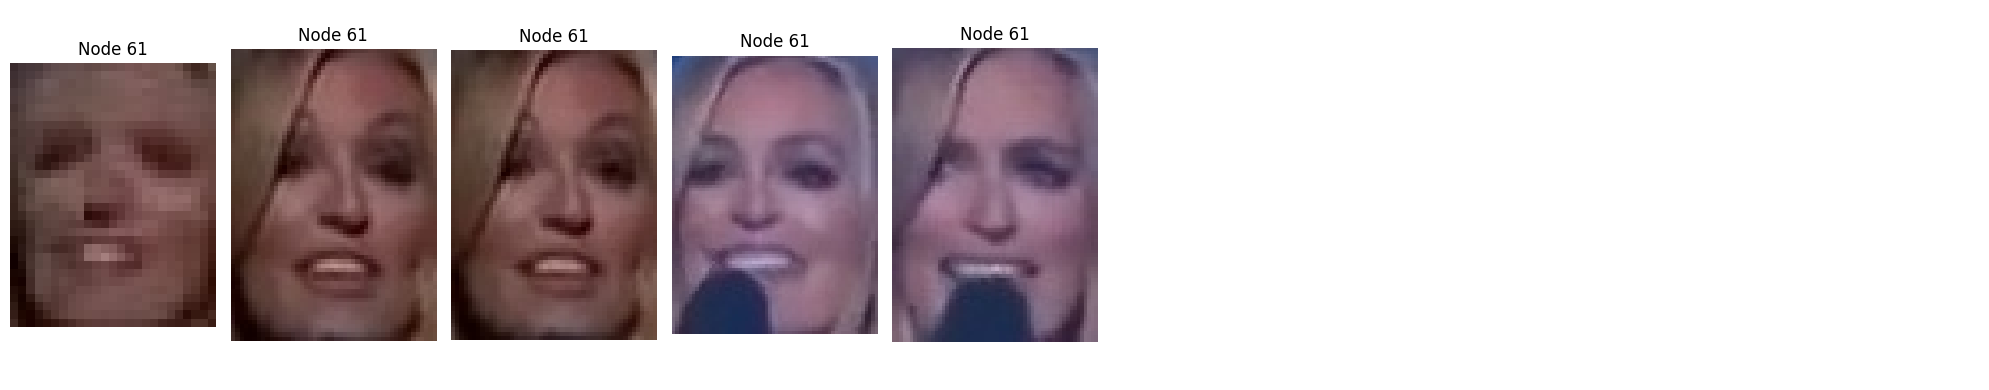

-------------------------------------------------- Image Node 62 --------------------------------------------------
Connected Nodes: []
Connected Nodes Contents: []


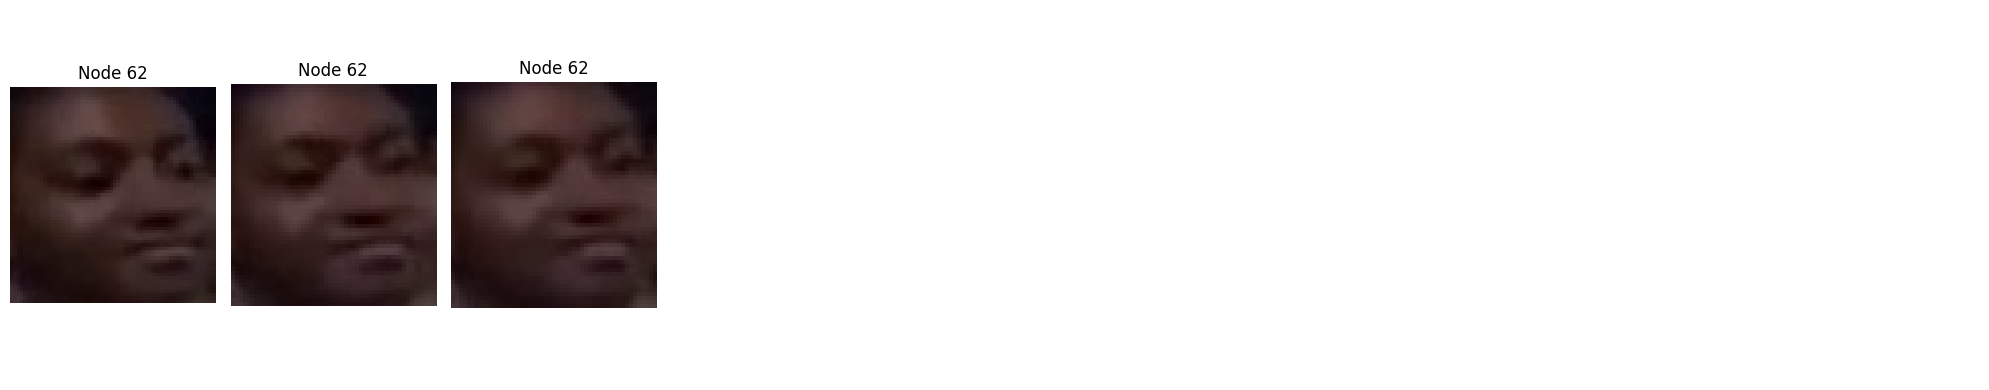

-------------------------------------------------- Image Node 63 --------------------------------------------------
Connected Nodes: []
Connected Nodes Contents: []


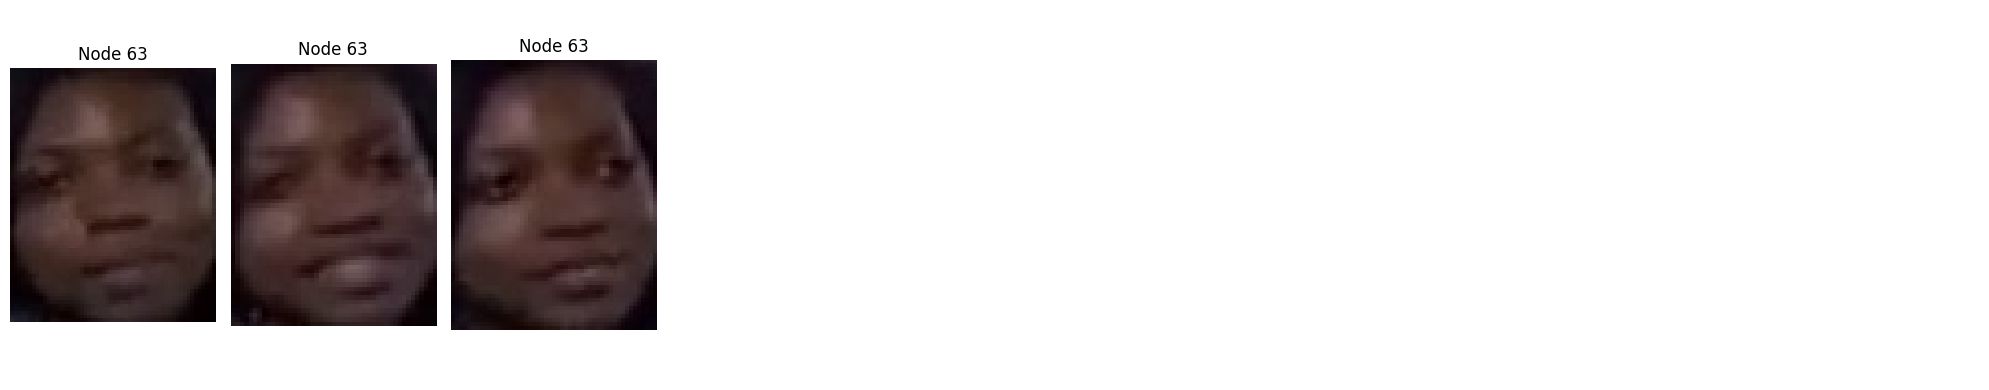

-------------------------------------------------- Image Node 77 --------------------------------------------------
Connected Nodes: [84, 86, 91, 92, 93, 95]
Connected Nodes Contents: [['<face_77> carries a large box while wearing a bandana and a patterned shirt.'], ['<face_77> and the woman in black stand back to back.'], ['<face_77> and the woman in black move boxes with a hand truck as part of the dance routine.'], ['Equivalence: <face_77>, <voice_76>.'], ['<face_77> is a dancer.'], ['<face_77> and the woman in black are coworkers at a moving company.']]


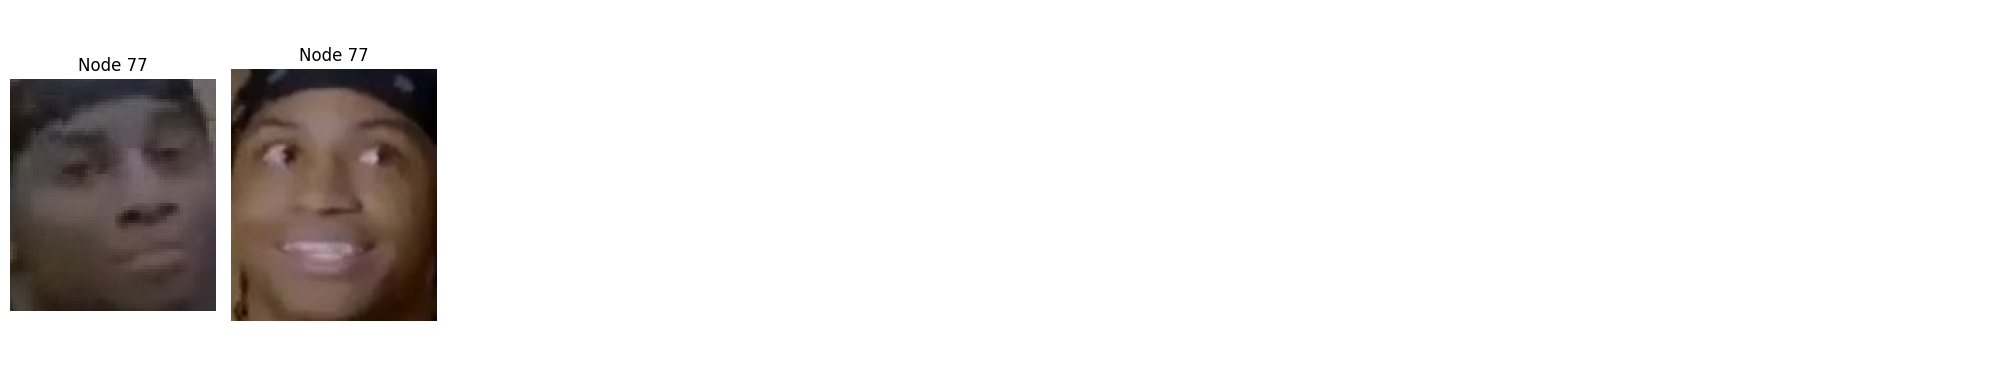

-------------------------------------------------- Image Node 212 --------------------------------------------------
Connected Nodes: [1027, 1031, 1032, 1033, 1035, 1036, 1038, 1039, 708, 710, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 215, 216, 727, 218, 729, 221, 222, 227, 228, 230, 232, 233, 234, 235, 240, 246, 247, 255, 265, 266, 268, 269, 270, 275, 276, 277, 278, 287, 288, 292, 294, 295, 296, 300, 303, 304, 305, 306, 307, 308, 309, 310, 1334, 1336, 313, 1337, 1338, 1345, 1346, 1354, 1360, 1363, 1368, 1370, 1371, 354, 356, 357, 358, 359, 360, 361, 362, 363, 366, 367, 368, 369, 373, 375, 378, 379, 380, 387, 950, 951, 953, 957, 961, 963, 965, 970, 971, 974, 975, 979, 980, 982, 985, 988, 989, 1001, 1002, 1004, 1007, 1019, 1022]
Connected Nodes Contents: [['<voice_762> announces the names of the two dancers, <face_837> and <face_212>.'], ['<voice_26> instructs viewers how to vote for <face_837> and <face_212>.'], ['<face_212> and <face_837> wear matching pale

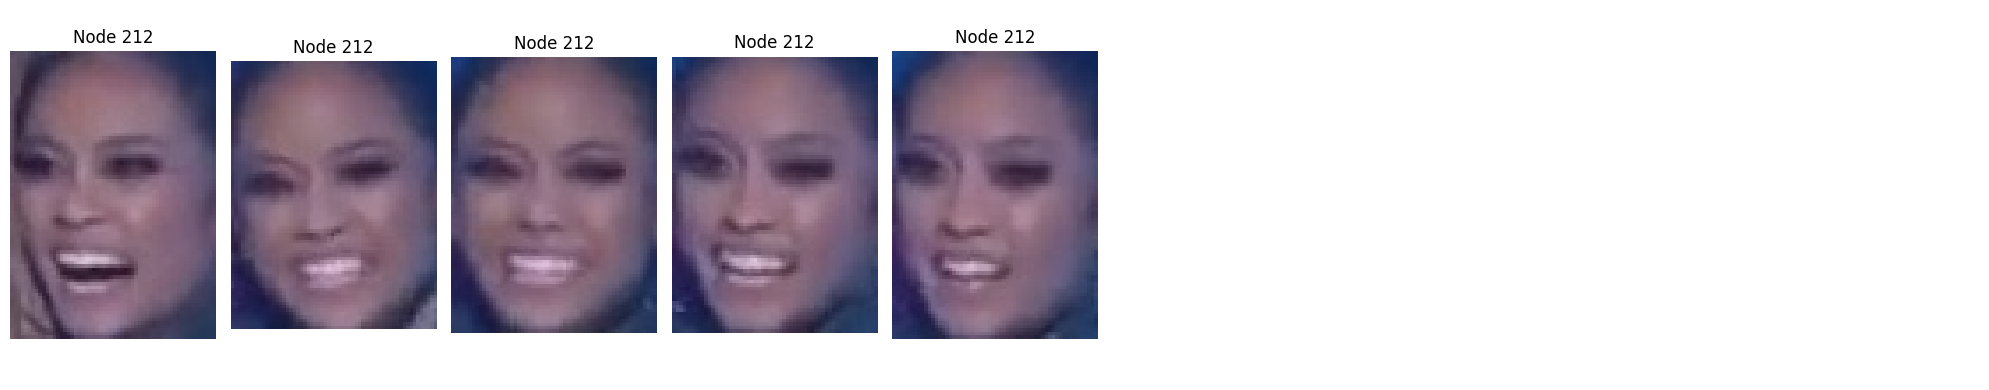

-------------------------------------------------- Image Node 213 --------------------------------------------------
Connected Nodes: [256, 583, 584, 585, 586, 595, 1247, 224, 1248, 1249, 1250, 223, 229, 1253, 231, 1255, 233, 1256, 1260, 1262, 241, 242]
Connected Nodes Contents: [['<face_213> is a judge on a dance competition show.'], ['<face_213> wears a gray suit, white shirt, and black hat.'], ["<face_213> speaks to <face_527>, expressing gladness that <face_527> didn't make it on the show in the past."], ['<face_213> explains that the rejections prepared <face_527> for going all the way this time.'], ['<face_213> tells <face_527> that he is proud of <face_527>.'], ['<face_213> expresses pride and encouragement towards <face_527>.'], ['<face_213> wears a gray suit jacket, a white undershirt, and a dark-colored hat.'], ["<face_213> says, 'Yes, yes. Randy Half, that was crazy. Y'all make anything fun. I'm trying to move tomorrow. Like if it's going to be like that, kind of late. I mea

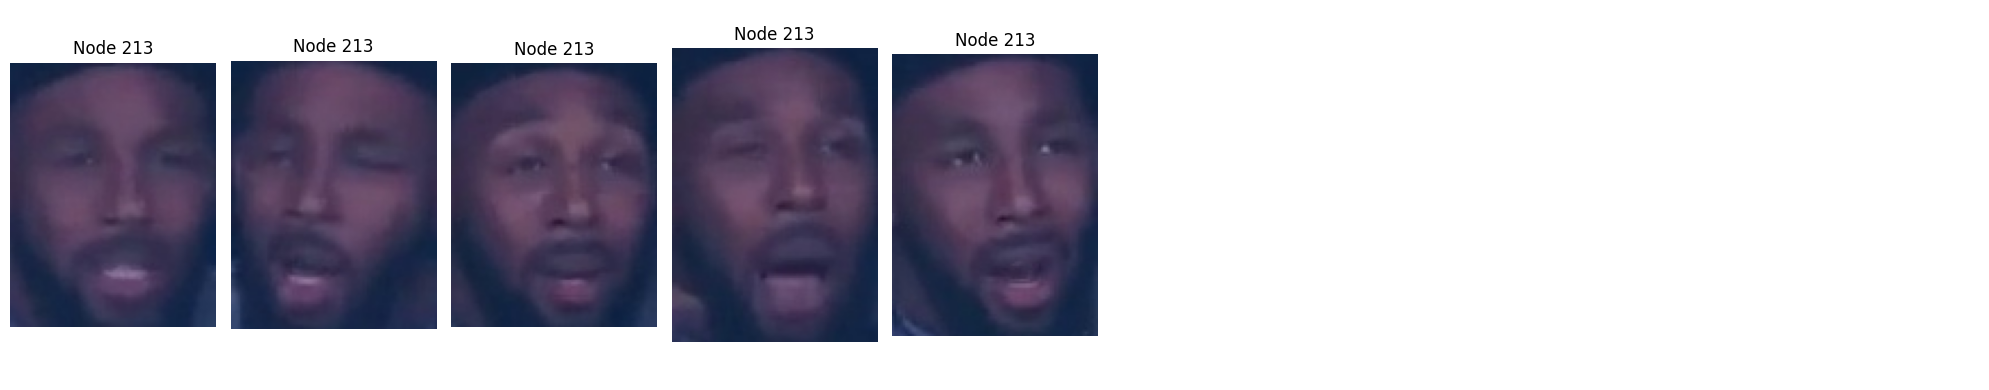

-------------------------------------------------- Image Node 239 --------------------------------------------------
Connected Nodes: [258, 260, 1028, 1030, 264, 265, 266, 267, 270, 271, 272, 1039, 275, 278, 535, 534, 540, 541, 542, 544, 546, 548, 549, 1189, 1195, 1202, 1203, 1209, 1212, 1213, 249, 250, 251, 252, 254]
Connected Nodes Contents: [['<face_239> is a judge on the dance competition show.'], ['<face_239> is captivated by a dancer named Fixtion.'], ["<face_61>, <face_239>, and two other judges sit at a table labeled 'SO YOU THINK YOU CAN DANCE'."], ['<face_239> wears a black top with colorful floral embellishments.'], ["<face_239> sits at a judge's table on a stage, wearing a black top decorated with sequins and colorful beads."], ['<face_239> claps her hands and smiles as she speaks to <face_212>.'], ['<face_212> smiles and looks at <face_239>.'], ["<face_239> says: 'Hannahlei, you special delivery. You know what I mean? You just hit it, you slayed it. All the What I don't un

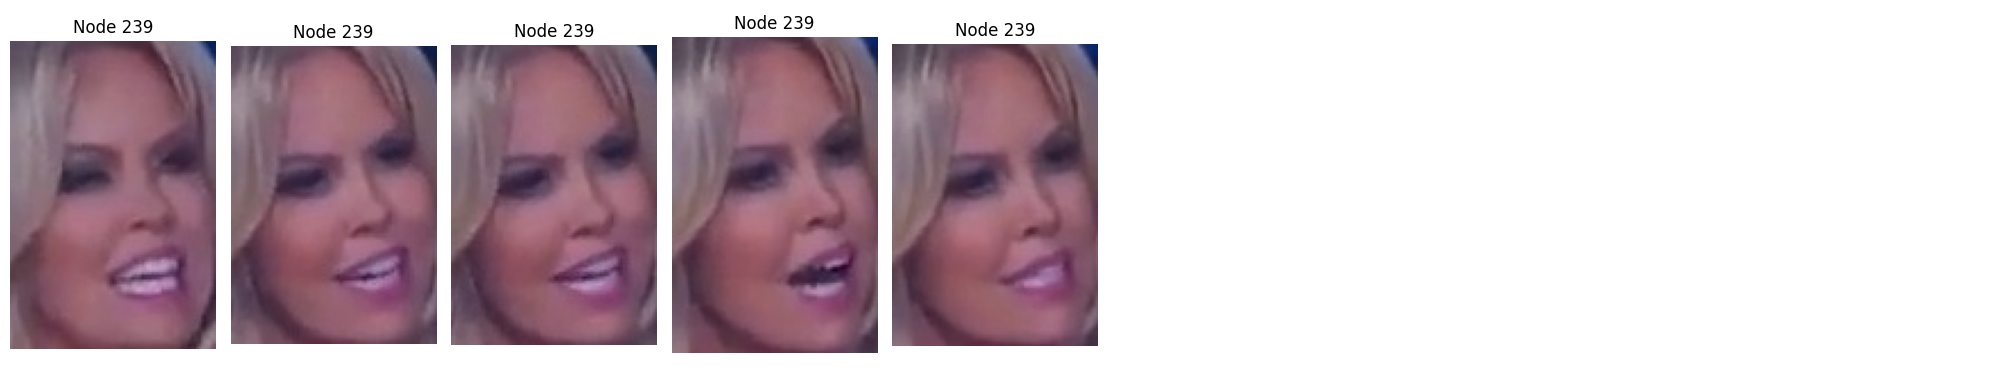

-------------------------------------------------- Image Node 282 --------------------------------------------------
Connected Nodes: [576, 986, 580, 293, 976, 977, 978, 979, 989, 285, 572, 573, 286]
Connected Nodes Contents: [['<face_282> expresses empathy and encouragement.'], ['<face_282> is a judge on the show.'], ['Being vulnerable is viewed as a strength in artistic expression by <face_282>.'], ['Equivalence: <face_282>, <voice_26>.'], ["<face_282>, sitting at the judges' table, speaks into a microphone."], ["<face_282> agrees with a previous judge's assessment, acknowledging that the two on stage are competitors."], ['<face_282> praises the mirroring in the performance.'], ['<face_282> expresses joy at watching <face_212> and <face_837> dance throughout the season.'], ["<face_61>, <face_282>, and the man in the gray suit praise <face_212> and <face_837>'s performance."], ["<face_282> sits at a judge's table, wearing a sparkly taupe top."], ['<face_282> speaks to the audience.'],

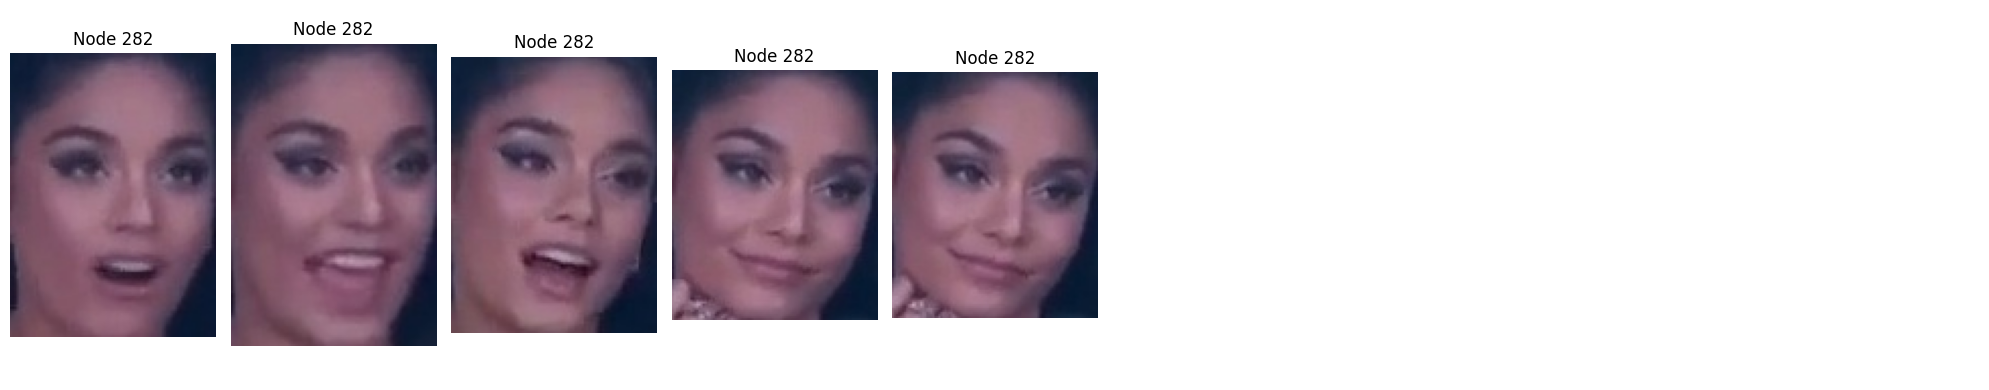

-------------------------------------------------- Image Node 318 --------------------------------------------------
Connected Nodes: [321, 322, 323, 330, 333, 335, 336, 340, 343, 344, 345, 346, 347, 348]
Connected Nodes Contents: [['<face_318> and a woman sit together.'], ['<face_318> is wearing a pale yellow polo shirt.'], ['The woman next to <face_318> wears an off-the-shoulder teal top.'], ["<face_318>'s companion speaks to Hannahlei, laughing as she does."], ['<face_318> and his companion sit together, smiling.'], ['Hannahlei hugs <face_318> and his companion.'], ["<face_318>'s companion wears a coral dress."], ['<face_318> and his companion are seen in the audience, clapping for Hannahlei.'], ['Equivalence: <face_318>, <voice_316>.'], ["Equivalence: <face_318>'s companion, <voice_317>."], ["<face_318>'s name is Tony Cabanilla."], ["Hannahlei is <face_318>'s daughter."], ['<face_318> and his companion are supportive and proud of Hannahlei.'], ["<face_318>'s companion is emotionall

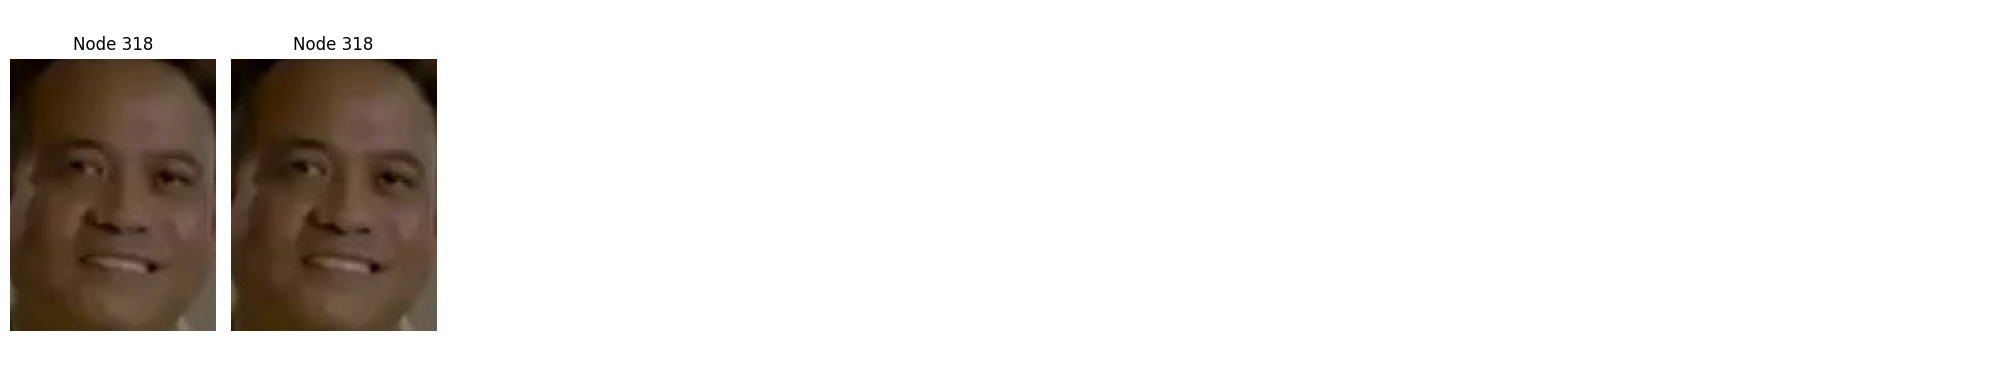

-------------------------------------------------- Image Node 353 --------------------------------------------------
Connected Nodes: [384, 385, 354, 355, 387, 358, 360, 362, 364, 365, 368, 369, 373, 374, 376, 377, 379]
Connected Nodes Contents: [['<face_353> returns to the stage in front of the audience.'], ['<face_353> speaks into the microphone, welcoming viewers back and announcing voting will open soon.'], ['<face_353> and <face_212> stand on a stage with a blue background.'], ['<face_353> wears a sparkly purple dress and holds a microphone.'], ['<face_353> and <face_212> have a positive and supportive relationship.'], ['<face_353> asks <face_212> what happens to her when she steps on stage.'], ['<face_353> asks <face_212> what she will remember most about the competition.'], ['<face_353> introduces <face_212> to the audience as Annalay.'], ['Equivalence: <face_353>, <voice_26>.'], ['<face_353> is a host or interviewer.'], ['<face_353> and <face_212> have a professional and friend

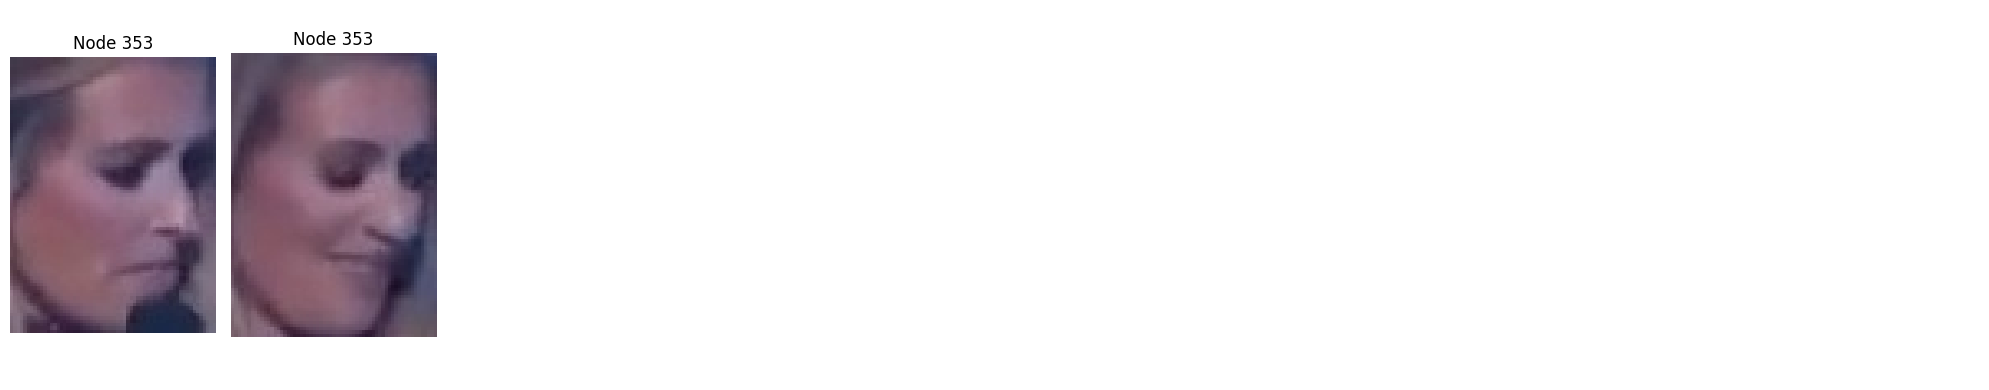

-------------------------------------------------- Image Node 418 --------------------------------------------------
Connected Nodes: [448, 451, 421, 422, 453, 455, 456, 426, 457, 460, 429, 431, 435, 438, 439, 446, 447]
Connected Nodes Contents: [["The blonde woman performs a leg extension with <face_418>'s help."], ['The blonde woman and <face_418> share a hug in the studio.'], ['<voice_391> is shown in a dance studio with a woman and <face_418>.'], ['<voice_391>, wearing a black crop top and black leggings, talks with the woman, and <face_418>.'], ['The blonde woman and <face_418> are now on a dimly lit stage, performing a contemporary dance routine.'], ['Equivalence: <face_418>, <voice_442>.'], ['<face_418> is a dance instructor or choreographer.'], ['<voice_391> and <face_418> practice dance moves.'], ['<face_418> is supportive and encouraging of the blonde woman.'], ['<face_418> and the blonde woman have a close working relationship, possibly mentor-mentee.'], ['<voice_391> and <f

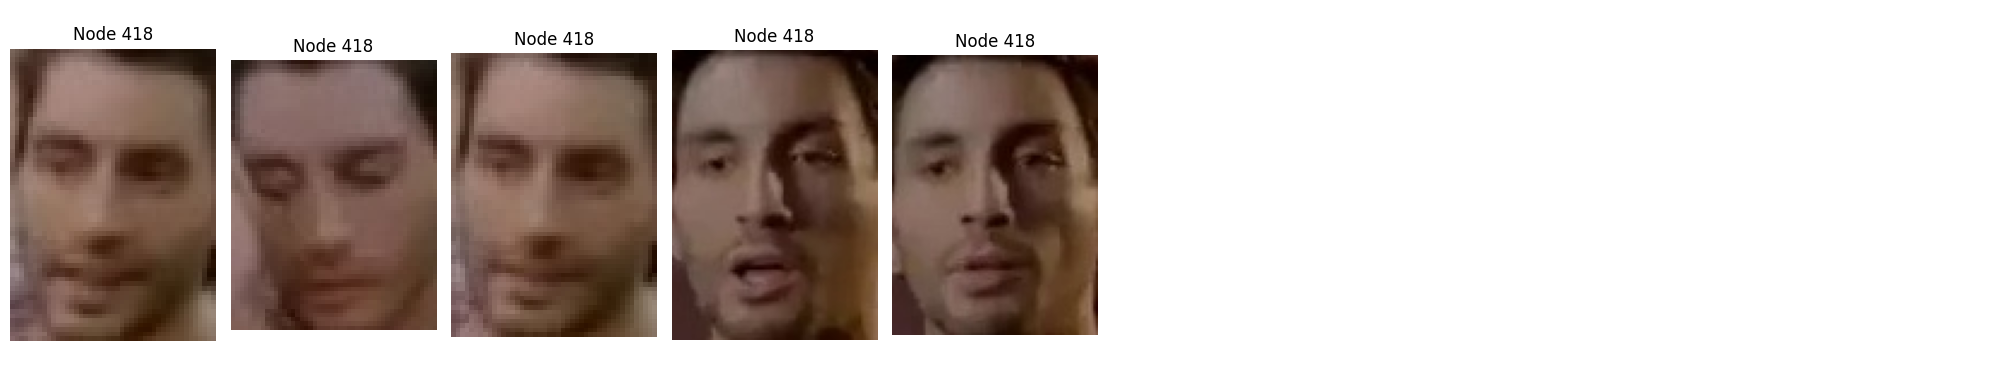

-------------------------------------------------- Image Node 419 --------------------------------------------------
Connected Nodes: [1088, 452, 432, 433, 434, 436, 437, 438, 439, 1079, 441, 1082, 1084, 1086]
Connected Nodes Contents: [["The main event is <face_419> and <face_1069>'s cha-cha performance."], ['<face_419> is seen smiling.'], ['Equivalence: <face_419>, <voice_391>.'], ['Equivalence: <face_419>, <voice_415>.'], ['Equivalence: <face_419>, <voice_417>.'], ['<face_419> is a dancer.'], ['<face_419> is trained to appear strong and happy, but is working on expressing vulnerability through dance.'], ['<face_418> is supportive of <face_419> exploring vulnerability.'], ['The woman in the dance studio is a choreographer or instructor, guiding <face_419> and <face_418>.'], ['Equivalence: <face_419>, <voice_1067>.'], ['The overall tone is emotionally charged, as <face_419> confronts a personal challenge in her performance.'], ["<face_419>'s name is Jensen."], ['<face_1069> and <face_

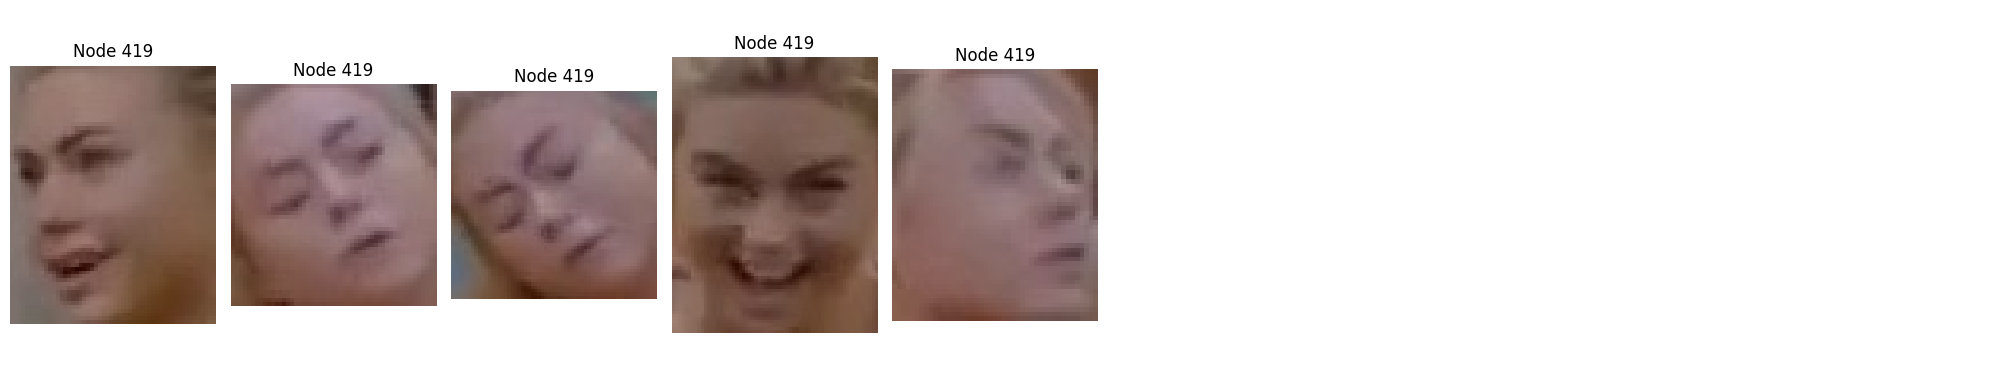

-------------------------------------------------- Image Node 527 --------------------------------------------------
Connected Nodes: [528, 530, 532, 537, 542, 543, 545, 547, 548, 549, 569, 571, 577, 578, 579, 584, 585, 586, 587, 588, 589, 592, 594, 595, 596, 598, 599, 604, 606, 608, 616, 618, 620, 1186, 1187, 1189, 1191, 1192, 1193, 1194, 1195, 1199, 1201, 1202, 1204, 1206, 1210, 1211, 1212, 1216, 1217, 1223, 1225, 1227, 1235, 1236, 1240, 1241, 1242, 1249, 1252, 1253, 1259, 1260, 1266, 1269, 1270, 1273, 1275, 1276, 1281, 1282, 1283, 1284, 1347, 1348, 1360, 1364, 1368, 1370, 1371, 1372, 1373, 1374]
Connected Nodes Contents: [['<voice_26> speaks to <face_527>, offering advice and encouragement.'], ["<face_527> listens attentively to <voice_26>'s words."], ['<face_527> smiles warmly at <voice_26>.'], ['<face_527> appears emotional, possibly on the verge of tears.'], ["<face_527> listens to <face_239>'s comments, maintaining a composed yet emotional expression."], ['Equivalence: <face_527

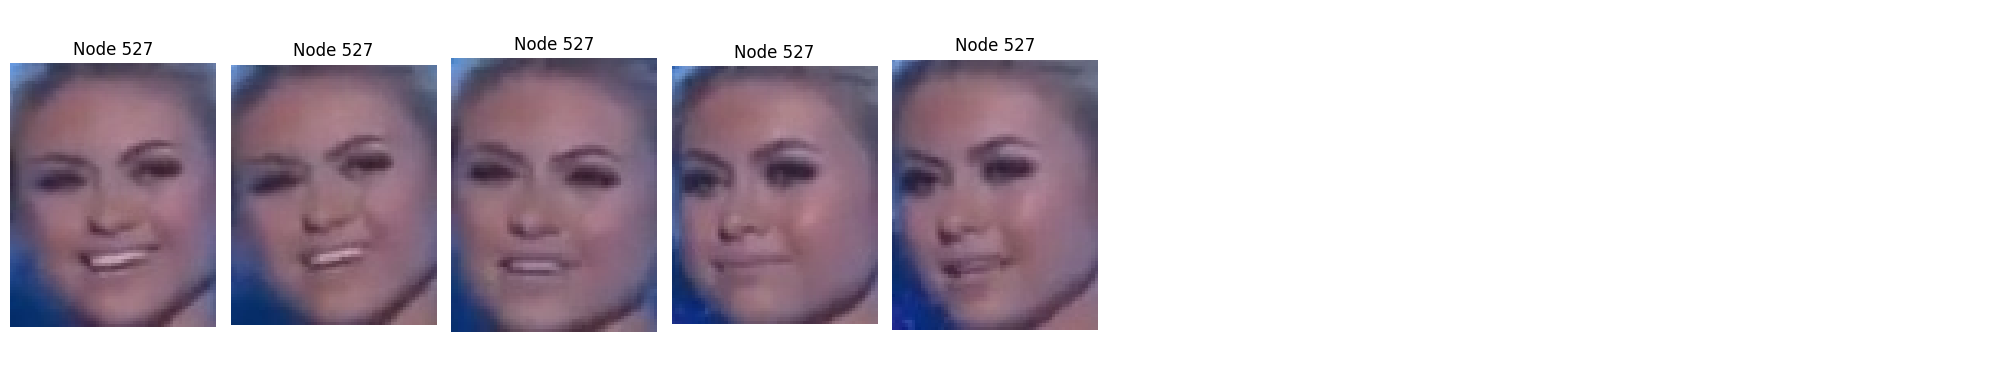

-------------------------------------------------- Image Node 707 --------------------------------------------------
Connected Nodes: [801, 802, 803, 804, 806, 807, 808, 809, 810, 715, 716, 717, 718, 719, 720, 721, 726, 727, 728, 729]
Connected Nodes Contents: [['<voice_26> asks <face_707> if <face_707> has been there every week.'], ['<face_707>, wearing a light pink, long-sleeved shirt and jeans, responds "yes."'], ["<voice_26> expresses surprise that she hasn't met <face_707> before, despite speaking with everyone there."], ['<voice_26> tells <face_707> to keep her updated on how things progress.'], ['The people in the audience, which includes <face_796>, <face_797>, <face_707>, and <face_61>, clap and cheer.'], ['Equivalence: <face_707>, <voice_795>.'], ['<face_707> is a dancer.'], ["<face_61> admires <face_707>'s dancing abilities."], ['<face_61> and <face_707> have a friendly interaction.'], ['<face_212> dances with <face_707> on stage.'], ['<face_212> says that <face_707> was her

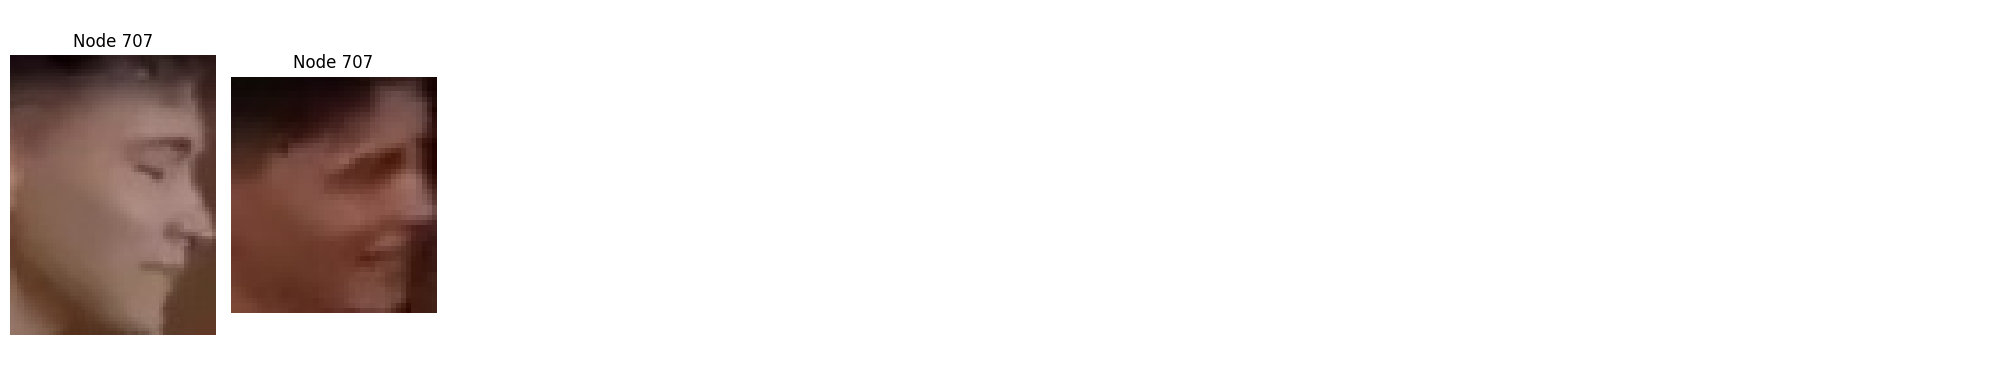

-------------------------------------------------- Image Node 796 --------------------------------------------------
Connected Nodes: [811, 806]
Connected Nodes Contents: [['The audience members, including <face_796>, <face_797>, and others, are supportive and enthusiastic.'], ['The people in the audience, which includes <face_796>, <face_797>, <face_707>, and <face_61>, clap and cheer.']]


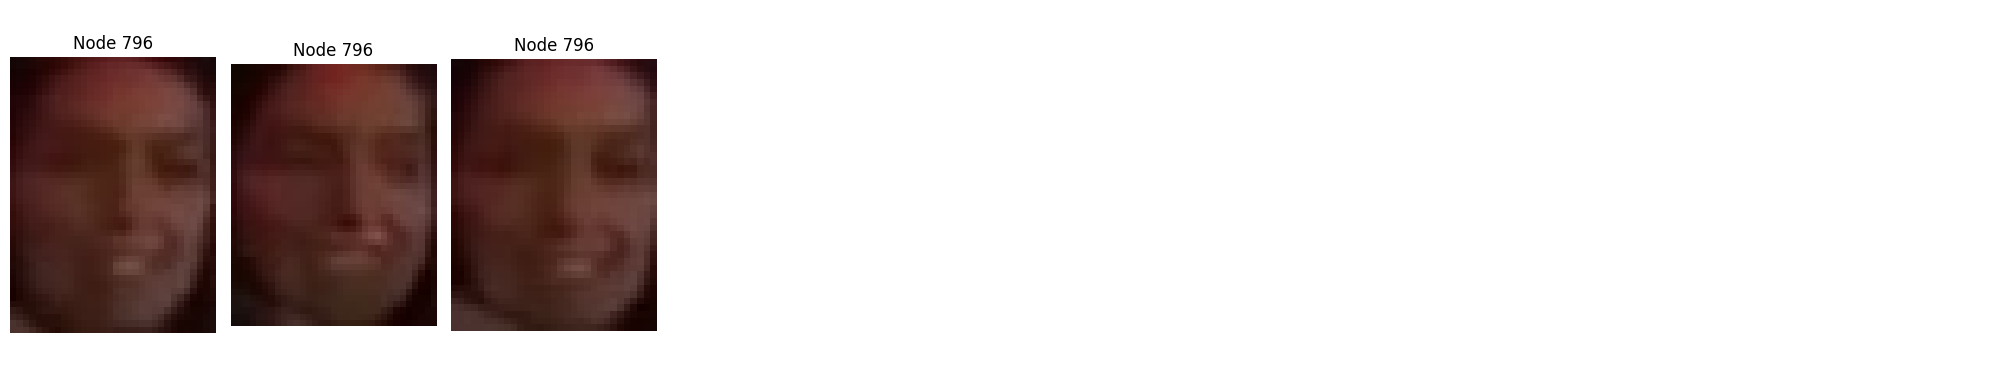

-------------------------------------------------- Image Node 797 --------------------------------------------------
Connected Nodes: [811, 806]
Connected Nodes Contents: [['The audience members, including <face_796>, <face_797>, and others, are supportive and enthusiastic.'], ['The people in the audience, which includes <face_796>, <face_797>, <face_707>, and <face_61>, clap and cheer.']]


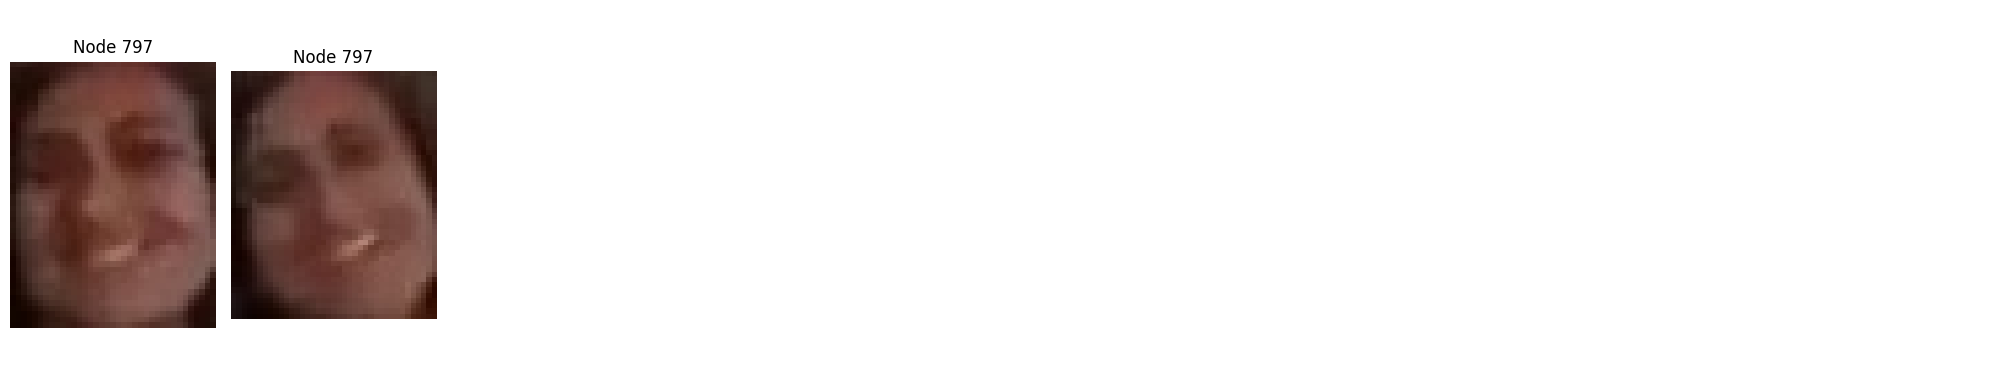

-------------------------------------------------- Image Node 798 --------------------------------------------------
Connected Nodes: []
Connected Nodes Contents: []


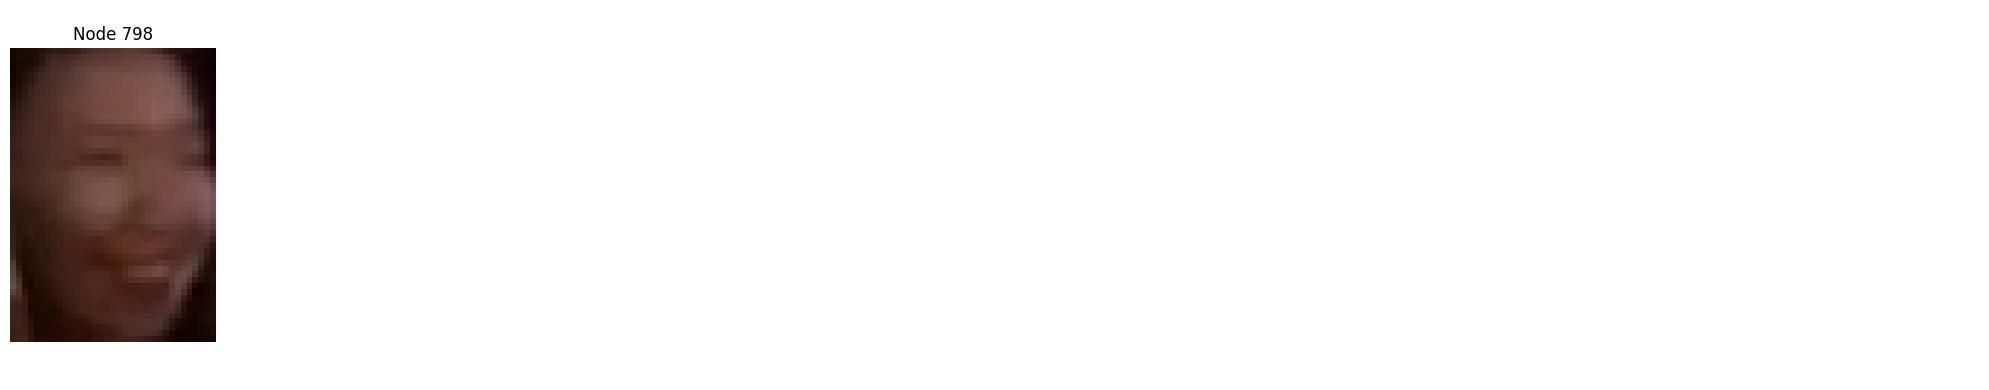

-------------------------------------------------- Image Node 837 --------------------------------------------------
Connected Nodes: [1027, 1031, 1032, 1033, 1034, 1035, 1038, 1039, 1352, 1354, 950, 952, 953, 1360, 957, 1345, 1346, 963, 965, 839, 840, 841, 970, 843, 844, 845, 846, 972, 848, 974, 850, 851, 852, 975, 979, 980, 982, 985, 1363, 1368, 988, 989, 1370, 1371, 1001, 1002, 1004, 1007, 1019, 1022]
Connected Nodes Contents: [['<voice_762> announces the names of the two dancers, <face_837> and <face_212>.'], ['<voice_26> instructs viewers how to vote for <face_837> and <face_212>.'], ['<face_212> and <face_837> wear matching pale, sheer long-sleeved tops and white pants.'], ['<face_212> and <face_837> stand onstage with <face_61>.'], ['<face_837> wears a white corset belt over her top.'], ['The audience applauds <face_212> and <face_837>.'], ['<face_212> and <face_837> are contestants on the show.'], ["<face_239> is very enthusiastic about <face_212> and <face_837>'s performance."

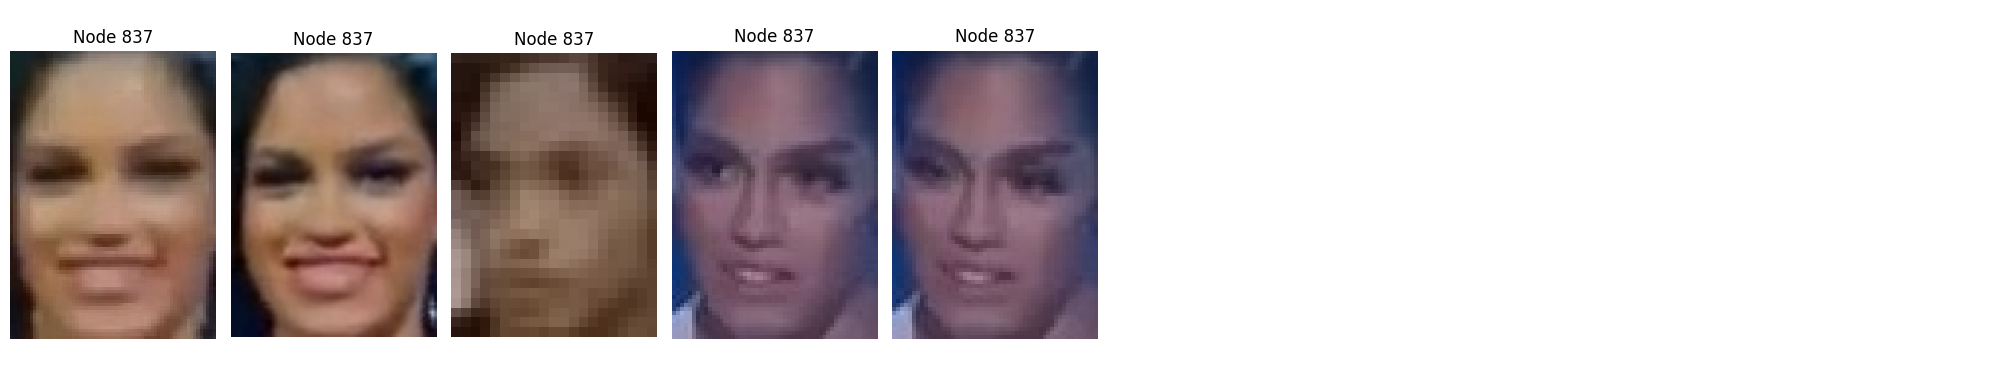

-------------------------------------------------- Image Node 838 --------------------------------------------------
Connected Nodes: [843, 844, 847, 849, 852]
Connected Nodes Contents: [['In a dance studio, <face_837> says that she and Hannahlei are dancing a contemporary piece choreographed by <face_838>.'], ['<face_837>, Hannahlei, and <face_838> rehearse the dance routine.'], ['<face_838> explains that the idea behind the routine is to show two girls who rely on each other having to fend for themselves.'], ["<face_838>'s name is Talia Favia."], ['<face_838> choreographed a contemporary dance for <face_837> and Hannahlei.']]


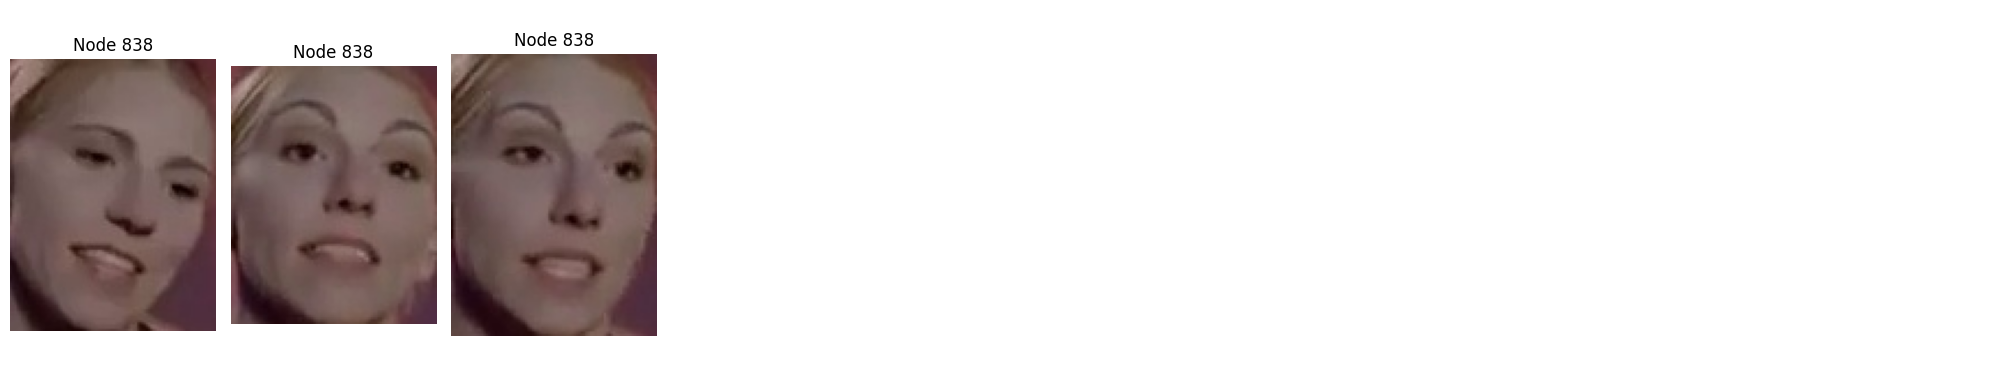

-------------------------------------------------- Image Node 948 --------------------------------------------------
Connected Nodes: [962, 964, 965, 966]
Connected Nodes Contents: [['Equivalence: <face_948>, <voice_2>.'], ['<face_948> is a judge on a dance competition show.'], ['<face_948> praises <face_837> and <face_212> for their synchronized dancing.'], ["<face_948> expresses uncertainty about the audience's voting outcome."]]


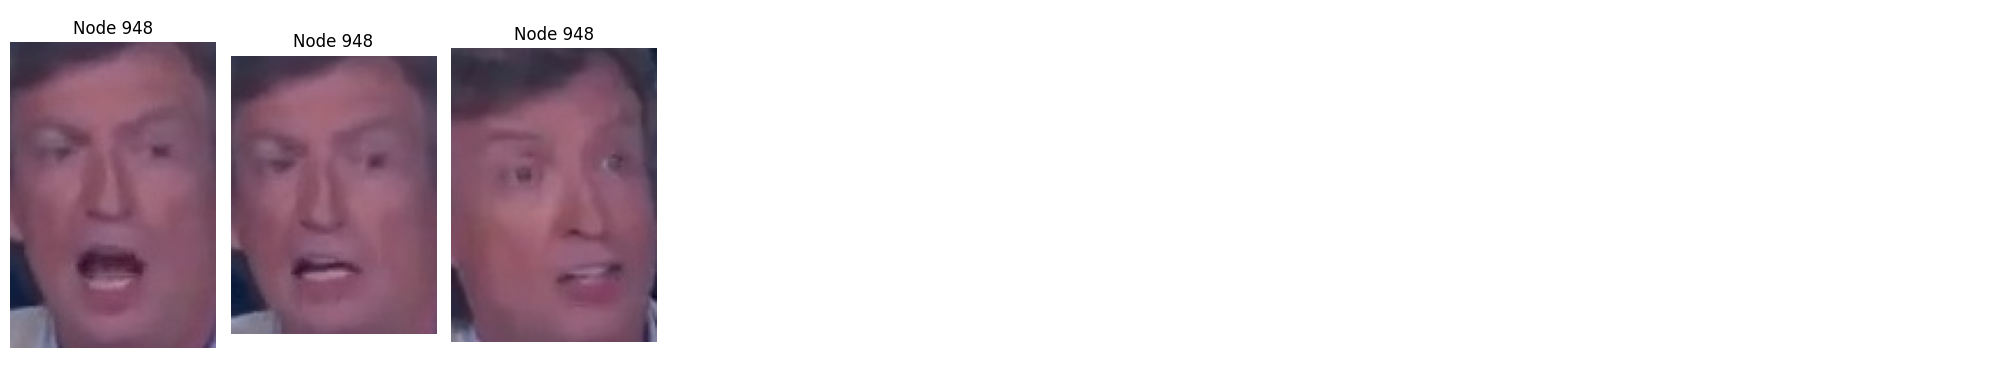

-------------------------------------------------- Image Node 995 --------------------------------------------------
Connected Nodes: [1000, 1021, 1006, 1015]
Connected Nodes Contents: [['<face_995> claps.'], ["<face_995> agrees with the man in the beige suit's opinion."], ['<face_995> listens to the man in the beige suit speak.'], ['<face_995> is a judge.']]


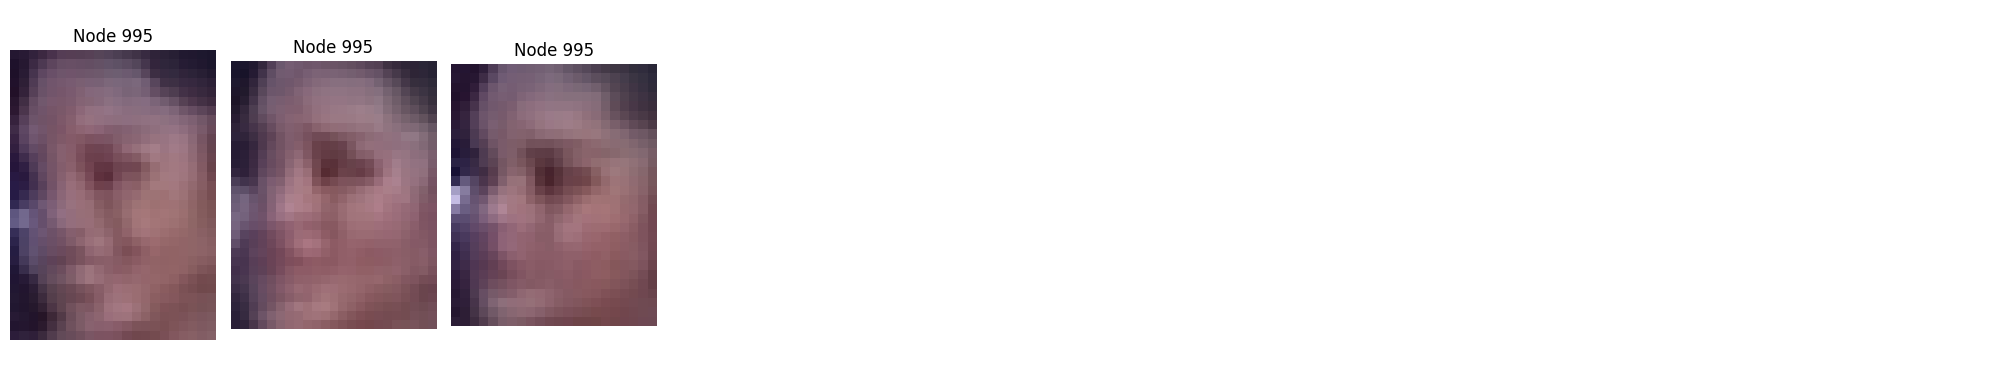

-------------------------------------------------- Image Node 996 --------------------------------------------------
Connected Nodes: []
Connected Nodes Contents: []


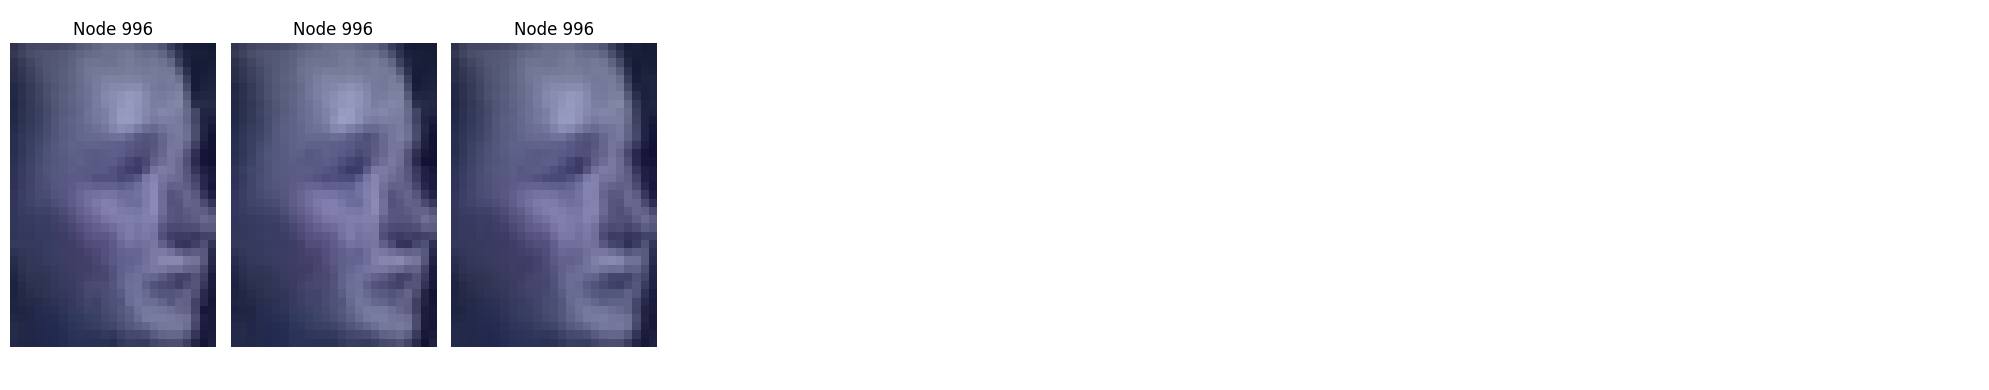

-------------------------------------------------- Image Node 1069 --------------------------------------------------
Connected Nodes: [1088, 1080, 1081, 1084, 1086]
Connected Nodes Contents: [["The main event is <face_419> and <face_1069>'s cha-cha performance."], ['Equivalence: <face_1069>, <voice_1066>.'], ["<face_1069>'s name is Slavik."], ['<face_1069> and <face_419> are dance partners.'], ['<face_419> and <face_1069> have a supportive and positive working relationship.']]


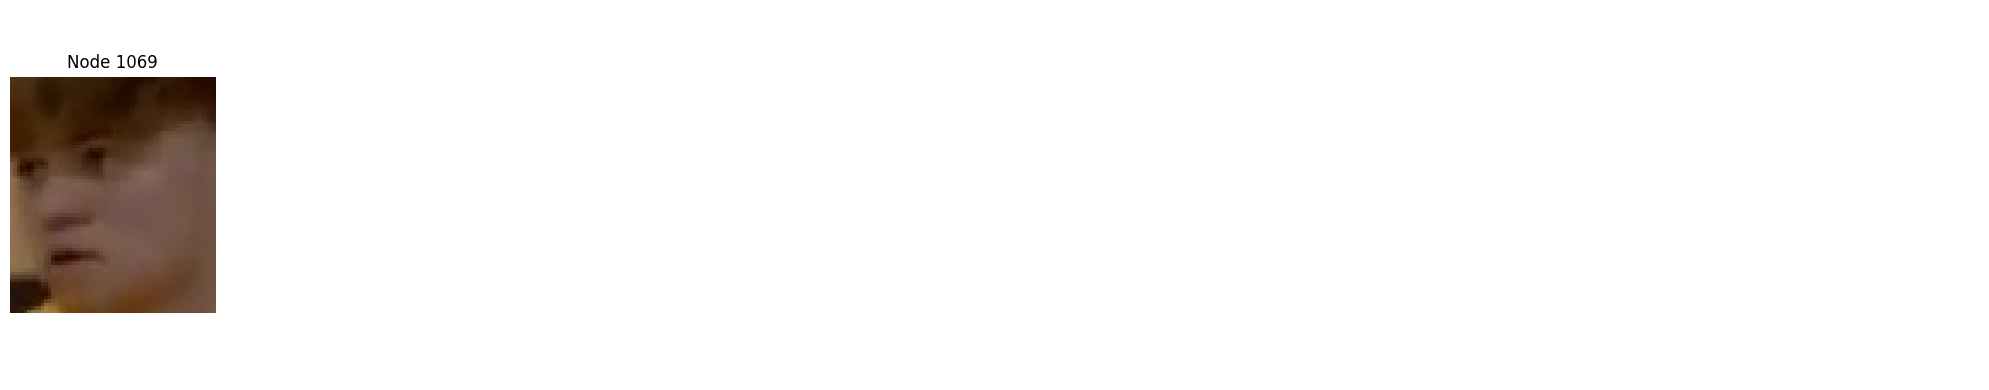

-------------------------------------------------- Image Node 1184 --------------------------------------------------
Connected Nodes: [1280, 1282, 1283, 1284, 1186, 1187, 1189, 1192, 1195, 1199, 1200, 1202, 1204, 1206, 1207, 1208, 1336, 1210, 1339, 1212, 1216, 1218, 1219, 1347, 1221, 1222, 1348, 1224, 1353, 1228, 1229, 1232, 1233, 1360, 1235, 1365, 1239, 1368, 1241, 1242, 1370, 1371, 1373, 1249, 1251, 1253, 1258, 1260, 1266, 1268, 1273, 1275, 1276]
Connected Nodes Contents: [['<face_1184> points at the screen.'], ['<face_1184> and <face_527> are a dance duo named Jensen and Slavik.'], ['<face_1184> and <face_527> are likely feeling a mix of excitement and anticipation as they await the results of the competition.'], ['<face_1184> and <face_527> have a supportive and close relationship, demonstrated by their physical closeness and shared smiles.'], ['<face_1184> and <face_527> walk towards a woman holding a microphone.'], ['The woman with the microphone speaks to <face_1184> and <face_

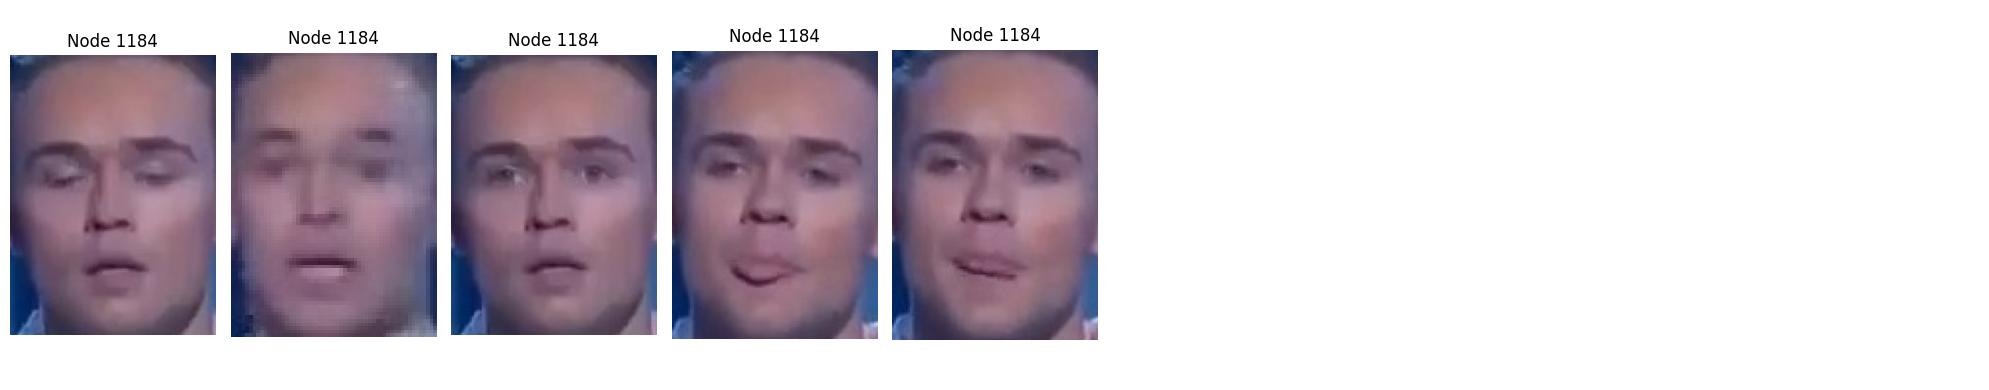

-------------------------------------------------- Voice Node 0 --------------------------------------------------
Contents: ["Whenever I'm looking up the stairs, they get so nervous, and then I hear the music, all of it goes away.", "I've done so many amazing dances on this show, but last week was one of the hardest weeks.", 'told me I agree with him. I think I was in my head. I got to come back this week, like I came in week one, stronger than I ever could have imagined.', "Becoming the winner of season 15, it would feel unreal. I won't be satisfied until I reach the goal that I set for myself."]
Connected Nodes: [4, 5, 6, 7, 12, 17, 18, 19, 20, 21, 22, 23, 27, 28, 30, 32, 33, 34, 35, 37, 38, 42, 43, 45, 46]
Connected Nodes Contents: [['A woman in a red dress hugs <voice_0>.'], ['Backstage, <voice_0> hugs two women.'], ['<voice_0> walks away.'], ['<voice_0>, in a black sweatshirt with red trim, talks about his pre-performance nerves.'], ['<voice_0>, in a rust-colored t-shirt, stands 

In [3]:
video_graph_path = (
    "/mnt/hdfs/foundation/longlin.kylin/mmagent/data/mems/CZ_1/-UhacNNM_HU_30_5_-1_10_20_0.3_0.6.pkl"
)
video_graph = load_video_graph(video_graph_path)
video_graph.visualize()

# print all episodic and semantic nodes
for node_id in video_graph.text_nodes:
    print(video_graph.nodes[node_id].metadata["contents"][0])

In [ ]:
import numpy as np
from tqdm import tqdm
import os
import json
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

from videograph import VideoGraph
from utils.general import *
from utils.video_processing import *
from utils.chat_api import *
from prompts import *

from face_processing import process_faces
from voice_processing import process_voices
from memory_processing import (
    process_captions,
    generate_captions_and_thinkings_with_ids,
)
from generate_memory import streaming_process_video

processing_config = json.load(open("configs/processing_config.json"))
memory_config = json.load(open("configs/memory_config.json"))

video_paths = ["/mnt/hdfs/foundation/longlin.kylin/mmagent/data/video_clips/PnvZZwlN2yk"]

save_dir = processing_config["save_dir"]
generated_memories = os.listdir(save_dir)
generated_memories = [generated_memory for generated_memory in generated_memories if generated_memory.endswith(".pkl")]
video_paths = [video_path for video_path in video_paths if generate_file_name(video_path)+".pkl" not in generated_memories]

# save_dir = processing_config["save_dir"]
# video_paths = ['/mnt/hdfs/foundation/longlin.kylin/mmagent/data/video_clips/EodRBU-HVEI']

cpu_count = multiprocessing.cpu_count()
max_workers = min(cpu_count, processing_config.get("max_parallel_videos", 4))

print(f"Using {max_workers} processes (CPU cores: {cpu_count})")

preprocessing = []

def process_single_video(video_path):
    video_graph = VideoGraph(**memory_config)
    try:
        streaming_process_video(video_graph, video_path, preprocessing=preprocessing)
    except Exception as e:
        log_dir = processing_config["log_dir"]
        os.makedirs(log_dir, exist_ok=True)
        with open(os.path.join(log_dir, f"generate_memory_error.log"), "a") as f:
            f.write(f"Error processing video {video_path}: {e}\n")

with ProcessPoolExecutor(max_workers=max_workers) as executor:
    list(tqdm(executor.map(process_single_video, video_paths), total=len(video_paths), desc="Processing videos"))